# 1. Convolutional Variational Autoencoder for CIFAR-10

## 1.1 Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import time
from scipy import linalg
from scipy.linalg import sqrtm
from torchvision import transforms
from torchvision.models import inception_v3
from torch.nn.functional import interpolate
import torchvision.utils as vutils
import scipy
import skimage
from skimage.metrics import structural_similarity as ssim

## 1.2 Settings

In [2]:
# Set hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 40
NUM_CLASSES = 10

In [3]:
# Set random seeds to enforce reproducibility
def set_all_seeds(seed):
    os.environ['PL_GLOBAL_SEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
set_all_seeds(RANDOM_SEED)

## 1.3 Dataset

In [5]:
# Load CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Check the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])
tensor([3, 6, 0, 3, 9, 6, 6, 2, 6, 2])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])


## 1.4 Model

In [7]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :32, :32]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, stride=1, kernel_size=3, bias=False, padding=1),  # 32*32 -> 32*32
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),  # 32*32 -> 16*16
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),  # 16*16 -> 8*8
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(64, 64, stride=1, kernel_size=3, bias=False, padding=1),  # 8*8 -> 8*8
            nn.LeakyReLU(0.1, inplace=True),

            nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(4096, 128)
        self.z_log_var = torch.nn.Linear(4096, 128)

        self.decoder = nn.Sequential(
            torch.nn.Linear(128, 4096),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, stride=1, kernel_size=3),  # 8*8 -> 10*10
            nn.LeakyReLU(0.1, inplace=True),

            nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),  # 10*10 -> 19*19
            nn.LeakyReLU(0.1, inplace=True),

            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),  # 19*19 -> 37*37
            nn.LeakyReLU(0.1, inplace=True),

            nn.ConvTranspose2d(32, 3, stride=1, kernel_size=3, padding=1),  # 37*37 -> 37*37

            Trim(),  # 37*37 -> 32*32

            nn.Sigmoid()
        )

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(z_log_var / 2.)
        eps = torch.randn_like(std)
        z = z_mean + eps * std
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [8]:
set_all_seeds(RANDOM_SEED)

model = VAE()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 1.5 Training

In [9]:
def train_vae(num_epochs, model, optimizer, train_loader, loss_fn=None, logging_interval=50, kld_weight=1):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        
        for batch_idx, (features, _) in enumerate(train_loader):
            encoded, z_mean, z_log_var, decoded = model(features)
            
            kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), axis=1)
            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() 
    
            recon_loss = loss_fn(decoded, features, reduction='none')
            recon_loss = recon_loss.view(batchsize, -1).sum(axis=1)
            recon_loss = recon_loss.mean() 
            
            loss = recon_loss + kld_weight * kl_div
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(recon_loss.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    return log_dict

In [10]:
log_dict = train_vae(num_epochs=NUM_EPOCHS, model=model, optimizer=optimizer, train_loader=train_loader)

Epoch: 001/040 | Batch 0000/0782 | Loss: 198.1081
Epoch: 001/040 | Batch 0050/0782 | Loss: 181.6523
Epoch: 001/040 | Batch 0100/0782 | Loss: 134.6035
Epoch: 001/040 | Batch 0150/0782 | Loss: 137.7878
Epoch: 001/040 | Batch 0200/0782 | Loss: 124.5876
Epoch: 001/040 | Batch 0250/0782 | Loss: 116.5606
Epoch: 001/040 | Batch 0300/0782 | Loss: 107.1719
Epoch: 001/040 | Batch 0350/0782 | Loss: 113.1563
Epoch: 001/040 | Batch 0400/0782 | Loss: 113.9785
Epoch: 001/040 | Batch 0450/0782 | Loss: 105.4264
Epoch: 001/040 | Batch 0500/0782 | Loss: 104.9899
Epoch: 001/040 | Batch 0550/0782 | Loss: 97.9136
Epoch: 001/040 | Batch 0600/0782 | Loss: 104.5903
Epoch: 001/040 | Batch 0650/0782 | Loss: 99.0160
Epoch: 001/040 | Batch 0700/0782 | Loss: 86.8141
Epoch: 001/040 | Batch 0750/0782 | Loss: 89.0192
Time elapsed: 1.59 min
Epoch: 002/040 | Batch 0000/0782 | Loss: 89.3398
Epoch: 002/040 | Batch 0050/0782 | Loss: 96.4135
Epoch: 002/040 | Batch 0100/0782 | Loss: 96.2904
Epoch: 002/040 | Batch 0150/0782 |

## 1.6 Evaluation

In [11]:
# Plot training loss
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):
    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    
    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:]) * 1.5
    ])
    

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations, ) / averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    # Set second x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs + 1))

    newpos = [e * iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())

    plt.tight_layout()

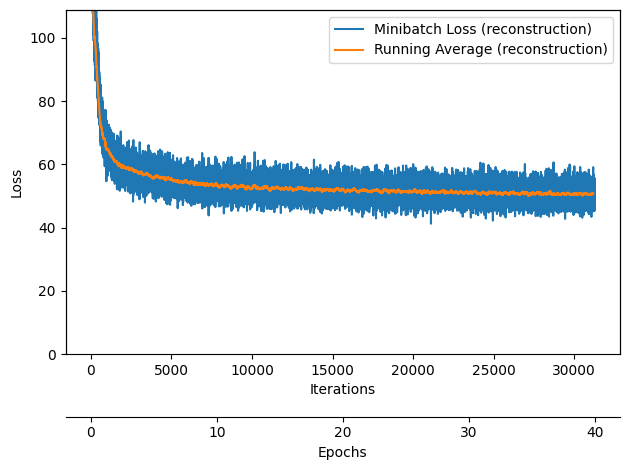

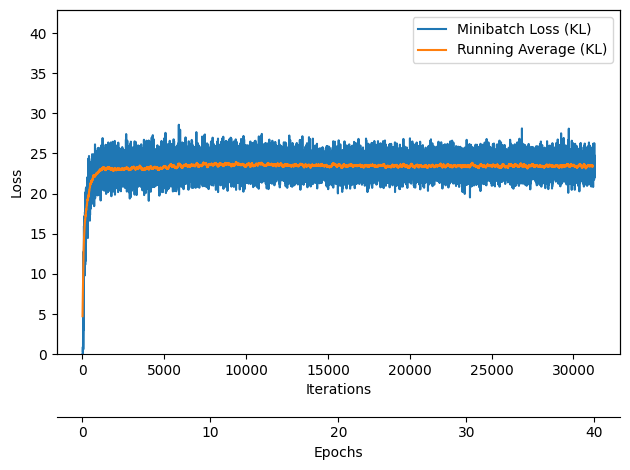

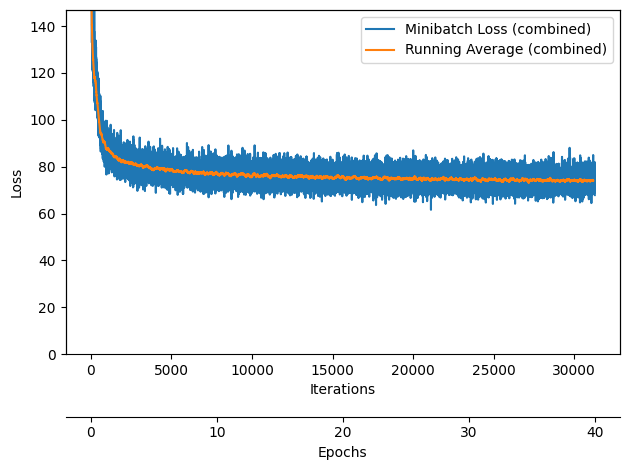

In [12]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

In [13]:
# Display reconstructed images (the first 32 images from the test dataset)
def plot_generated_images(data_loader, model):
    model.eval()
    
    rows = 2
    cols = 16
    n_images = rows * cols

    real_images_list = []
    gen_images_list = []
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        with torch.no_grad():
            encoded, z_mean, z_log_var, decoded_images = model(features)

        real_images = features

        real_images_list.append(real_images)
        gen_images_list.append(decoded_images)
        
        if len(real_images_list) > n_images:
            break

    real_images = torch.cat(real_images_list, dim=0)
    gen_images = torch.cat(gen_images_list, dim=0)
    
    # Plot original images from test dataset
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 2.5),squeeze=False)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    for i in range(rows):
        for j in range(cols):
            index = i*cols + j
            curr_img = real_images[index]       
            curr_img = np.transpose(curr_img, (1, 2, 0))
            axes[i,j].imshow(curr_img)
            axes[i,j].axis('off')
    plt.tight_layout(pad=0)
    plt.savefig('original.jpg')
    plt.show()

    # Plot reconstructed images
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 2.5),squeeze=False)
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(rows):
        for j in range(cols):
            index = i*cols + j
            curr_img = gen_images[index]       
            curr_img = np.transpose(curr_img, (1, 2, 0))
            axes[i,j].imshow(curr_img)
            axes[i,j].axis('off')
    plt.tight_layout(pad=0)
    plt.savefig('recon-batchsize-64-vae.jpg')
    plt.show()

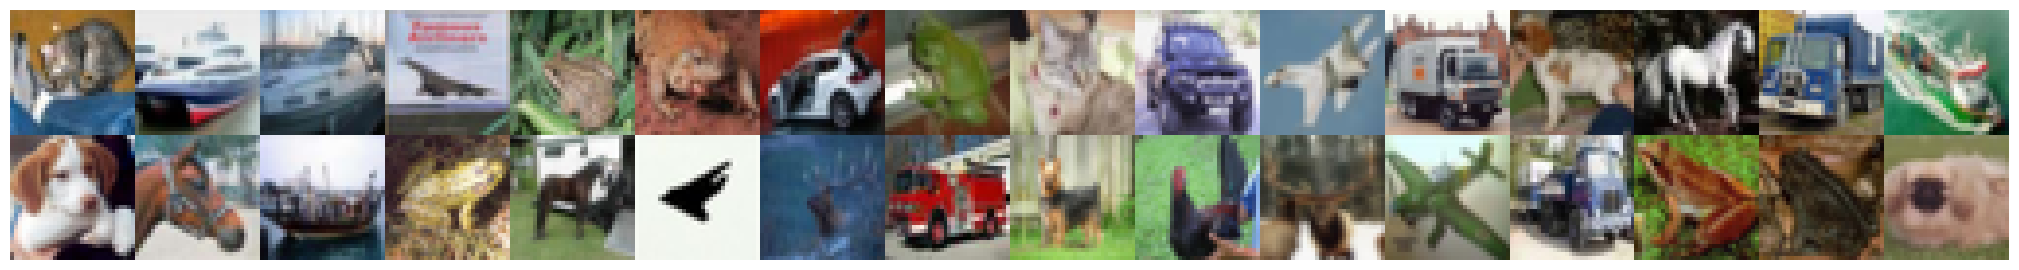

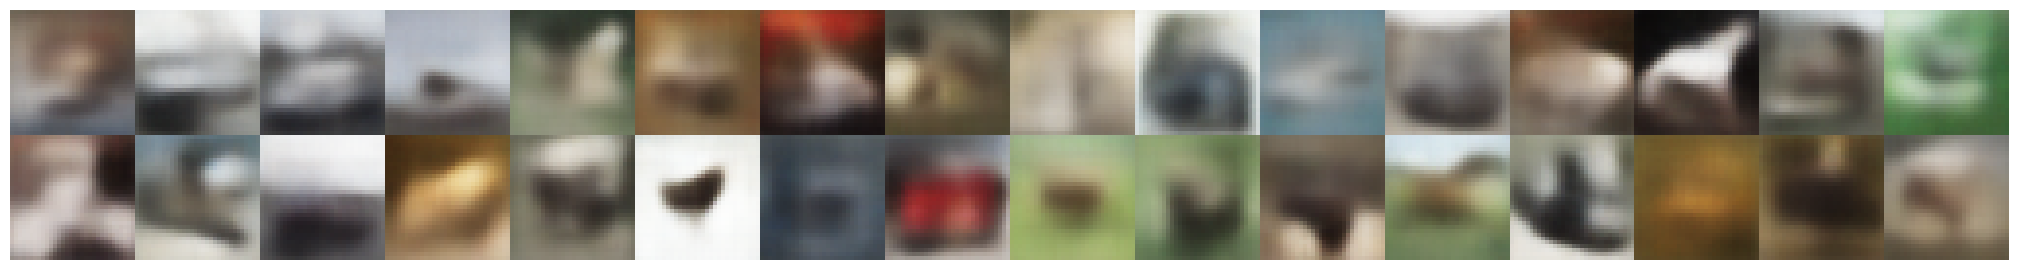

In [14]:
plot_generated_images(data_loader=test_loader, model=model) 

In [15]:
# Display generated images (randomly from latent space)
def plot_images_sampled_from_vae(model, latent_size, num_images=16):
    model.eval()
    
    with torch.no_grad():
        rand_features = torch.randn(num_images, latent_size)
        new_images = model.decoder(rand_features)

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 2.5), sharey=True)
        plt.subplots_adjust(wspace=0, hspace=0)
        
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))
            curr_img = np.transpose(curr_img, (1, 2, 0))
            ax.imshow(curr_img)
            ax.axis('off')

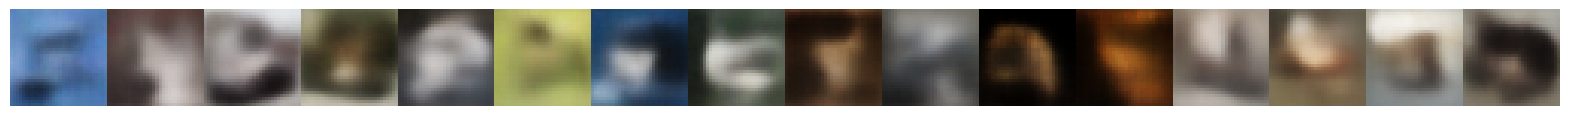

In [16]:
plot_images_sampled_from_vae(model=model, latent_size=128)
plt.show()

In [17]:
# Calculate SSIM
def evaluate_model(model, data_loader):
    model.eval()

    real_images_list = []
    gen_images_list = []
    
    for batch_idx, (features, _) in enumerate(data_loader):        
        with torch.no_grad():
            _, _, _, decoded_images = model(features)

        real_images = features

        real_images_list.append(real_images)
        gen_images_list.append(decoded_images)

    real_images = torch.cat(real_images_list, dim=0)
    gen_images = torch.cat(gen_images_list, dim=0)

    ssim_value = ssim(
    real_images.numpy(),
    gen_images.numpy(),
    multichannel=True,  # Set to True if your images have multiple channels (e.g., RGB)
    win_size=7,         # Set an odd value less than or equal to the smaller side of your images
    channel_axis=1,    # Set to 1 for PyTorch format (channels are the second axis)
    data_range=1.0
)
    
    print(f'SSIM: {ssim_value:.4f}')

In [19]:
evaluate_model(model=model, data_loader=test_loader)

SSIM: 0.7798
